In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/BeamCombining/100umCentral_1e16/'
lam = 0.8
tau = 35.

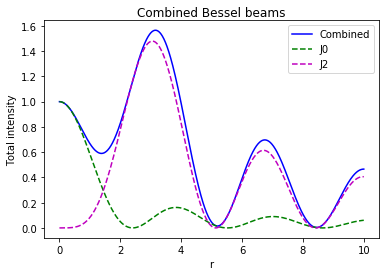

In [2]:
from scipy.special import jn
x = np.linspace(0, 10, 1000)
b = 2.5
j0 = jn(0, x)
j2 = b*jn(2, x)
plt.plot(x, j0**2 + j2**2, 'b', x, j0**2, 'g--', x, j2**2, 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J0', 'J2'])
plt.show()

In [3]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)
plt.plot(z, I)

params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 100,
    'lam' : lam
}
order = 1
r, E = bessel.bessel_expansion(params, z, I, n=order)

In [4]:
pulseParams = {
    'Nx' : 2**11,
    'Ny' : 2**11,
    'Nt' : 2**6,
    'X' : 20e3,
    'Y' : 20e3,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'order' : order,
    'r' : r,
    'E' : E*b
}

plasmaParams = {
    'Nx' : pulseParams['Nx'],
    'Ny' : pulseParams['Ny'],
    'Nz' : 2**8,
    'X' : pulseParams['X'],
    'Y' : pulseParams['Y'],
    'Z' : 2.0e6, 
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [5]:
# Test the higher order Bessel beam
pulseParams['name'] = 'J0Beam'
beam0 = laserbeam.RadialLaser(pulseParams)

In [6]:
beam0.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)

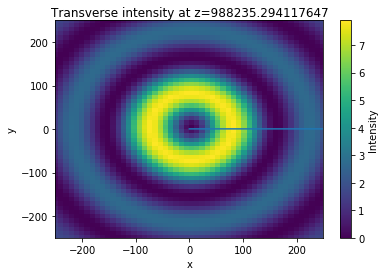

In [7]:
ind = 127
beam0.plot_intensity_at(ind, lim=[-250, 250])